In [1]:
import gc
import math
import json

import keras
import librosa
import os

import numpy
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
print(tf.config.list_physical_devices('GPU'))

def preprocess(dataset_path, num_mfcc=20, n_fft=2048, hop_length=512, num_segment=10, sample_rate=22050):
    samples_per_segment = int(sample_rate*30/num_segment)
    frames = 1 + (samples_per_segment - n_fft) // hop_length
    mfcc = np.empty(shape=(1000 * num_segment, num_mfcc, math.ceil(samples_per_segment / hop_length)), dtype=np.float32)
    labels = np.empty(shape=(1000 * num_segment), dtype=np.int32)

    count = 0
    for label_idx, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath == dataset_path:
            continue
        for f in sorted(filenames):
            if not f.endswith('.wav'):
                continue
            file_path = str(str(dirpath).split('\\')[-1]) + '/' + str(f)
            print("Track Name", file_path)

            try:
                y, sr = librosa.load(path=dirpath + "\\" + f, sr=sample_rate, dtype=np.float32)
            except:
                print("Exception")
                continue
            for n in range(num_segment):
                segment = y[samples_per_segment*n : samples_per_segment*(n + 1)]
                segment_mfcc = librosa.feature.mfcc(y=segment,sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length,                                          dtype=np.float32)
                if mfcc.shape[1] == segment_mfcc.shape[0] and mfcc.shape[2] == segment_mfcc.shape[1]:
                    mfcc[count] = segment_mfcc
                    labels[count] = label_idx - 1
                    count += 1
                else:
                    print("Error ", f)
                    # data["track_id"].append(f.split(".")[0])
    mfcc = np.delete(mfcc, np.s_[count:], axis=0)
    labels = np.delete(labels, np.s_[count:])
    return mfcc, labels

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
x, y = preprocess(r"C:\Users\dpetr\Desktop\sxoli\music genre classification\MFCC-CNN\Data\genres_original")

#     print(y.shape)
#     print(numpy.unique(y))
print(x.shape, x.dtype, y.shape, y.dtype)



Track Name blues/blues.00000.wav
Track Name blues/blues.00001.wav
Track Name blues/blues.00002.wav
Track Name blues/blues.00003.wav
Track Name blues/blues.00004.wav
Track Name blues/blues.00005.wav
Track Name blues/blues.00006.wav
Track Name blues/blues.00007.wav
Track Name blues/blues.00008.wav
Track Name blues/blues.00009.wav
Track Name blues/blues.00010.wav
Track Name blues/blues.00011.wav
Track Name blues/blues.00012.wav
Track Name blues/blues.00013.wav
Track Name blues/blues.00014.wav
Track Name blues/blues.00015.wav
Track Name blues/blues.00016.wav
Track Name blues/blues.00017.wav
Track Name blues/blues.00018.wav
Track Name blues/blues.00019.wav
Track Name blues/blues.00020.wav
Track Name blues/blues.00021.wav
Track Name blues/blues.00022.wav
Track Name blues/blues.00023.wav
Track Name blues/blues.00024.wav
Track Name blues/blues.00025.wav
Track Name blues/blues.00026.wav
Track Name blues/blues.00027.wav
Track Name blues/blues.00028.wav
Track Name blues/blues.00029.wav
Track Name

C:\Users\dpetr\miniconda3\envs\tf\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Exception
Track Name jazz/jazz.00055.wav
Track Name jazz/jazz.00056.wav
Track Name jazz/jazz.00057.wav
Track Name jazz/jazz.00058.wav
Track Name jazz/jazz.00059.wav
Track Name jazz/jazz.00060.wav
Track Name jazz/jazz.00061.wav
Track Name jazz/jazz.00062.wav
Track Name jazz/jazz.00063.wav
Track Name jazz/jazz.00064.wav
Track Name jazz/jazz.00065.wav
Track Name jazz/jazz.00066.wav
Track Name jazz/jazz.00067.wav
Track Name jazz/jazz.00068.wav
Track Name jazz/jazz.00069.wav
Track Name jazz/jazz.00070.wav
Track Name jazz/jazz.00071.wav
Track Name jazz/jazz.00072.wav
Track Name jazz/jazz.00073.wav
Track Name jazz/jazz.00074.wav
Track Name jazz/jazz.00075.wav
Track Name jazz/jazz.00076.wav
Track Name jazz/jazz.00077.wav
Track Name jazz/jazz.00078.wav
Track Name jazz/jazz.00079.wav
Track Name jazz/jazz.00080.wav
Track Name jazz/jazz.00081.wav
Track Name jazz/jazz.00082.wav
Track Name jazz/jazz.00083.wav
Track Name jazz/jazz.00084.wav
Track Name jazz/jazz.00085.wav
Track Name jazz/jazz.00086.wa

In [50]:
def build_model(input_shape):

    #create model
    model = keras.Sequential()

    #1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same')) # kernel size (2,2)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.2))

    #2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.2))

    #3rd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005))) # 512 best # l2 0.001
    model.add(keras.layers.Dropout(0.65)) #0.6

    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0005)))
    model.add(keras.layers.Dropout(0.65)) #0.6

    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

Train:  (7988, 20, 130, 1) (7988,) Validation:  (999, 20, 130, 1) (999,) Test:  (999, 20, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
                 

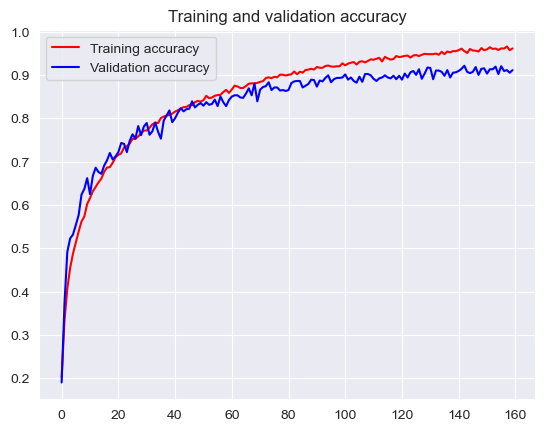

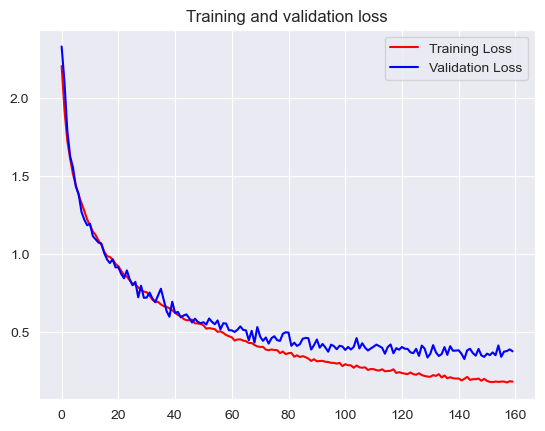

Accuracy on test set is:0.9189189076423645
Train:  (7988, 20, 130, 1) (7988,) Validation:  (999, 20, 130, 1) (999,) Test:  (999, 20, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 6

KeyboardInterrupt: 

In [48]:
x, y = shuffle(x, y)
skf = StratifiedKFold(n_splits=10)
# kf = KFold(n_splits=10, shuffle=True)
test_accuracies = []
for fold, (train_index, test_index) in enumerate(skf.split(x, y)):
    x_train = x[train_index]
    y_train = y[train_index]
    x_test = x[test_index]
    y_test = y[test_index]

    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=999, shuffle=True, stratify=y_train)
    x_train = x_train[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]

    print('Train: ', x_train.shape, y_train.shape, 'Validation: ', x_validation.shape, y_validation.shape, 'Test: ', x_test.shape, y_test.shape)

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean) / std
    x_validation = (x_validation - mean) / std
    x_test = (x_test - mean) / std


    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    model = build_model(input_shape)
    optimizer = keras.optimizers.Adam(learning_rate=0.00006) # 0.0001 # 0.00006
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    model.summary()

    checkpoint_filepath = 'CNN-KFoldCV_Checkpoint/' + str(fold)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True, initial_value_threshold=0.8, verbose=1)

    history = model.fit(x_train, y_train,
              validation_data=(x_validation, y_validation),
              epochs=160,
              batch_size=32, callbacks=[model_checkpoint_callback]
              )

    model.load_weights(checkpoint_filepath)

    test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
    test_accuracies.append(test_accuracy)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy' + str())
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    print("Accuracy on test set is:{}".format(test_accuracy))

    del model
    keras.backend.clear_session()
    gc.collect()

Train:  (8987, 20, 130, 1) (8987,) Test:  (999, 20, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
                                                       

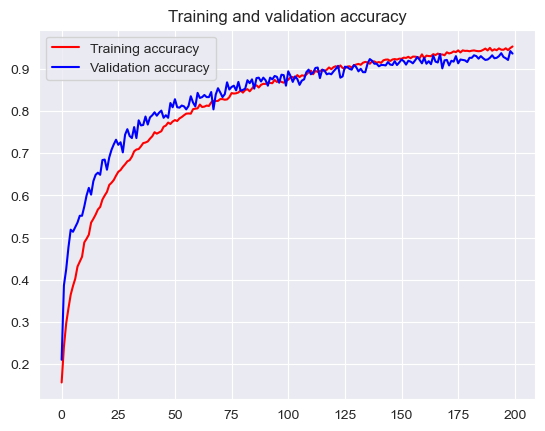

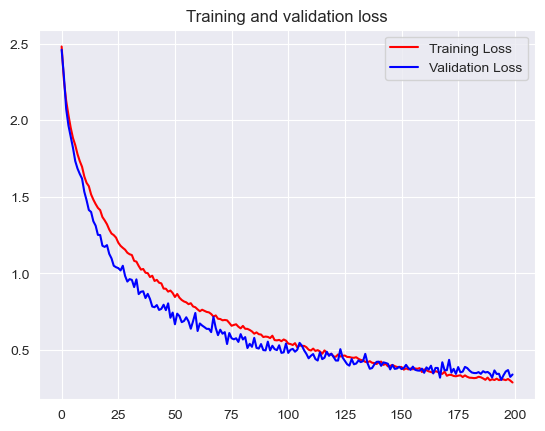

Accuracy on test set is:0.935935914516449
Train:  (8987, 20, 130, 1) (8987,) Test:  (999, 20, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
             

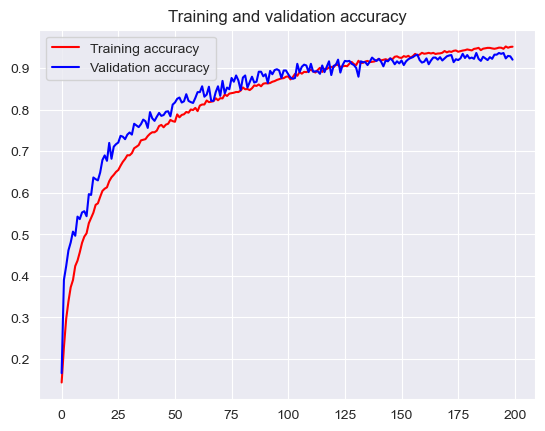

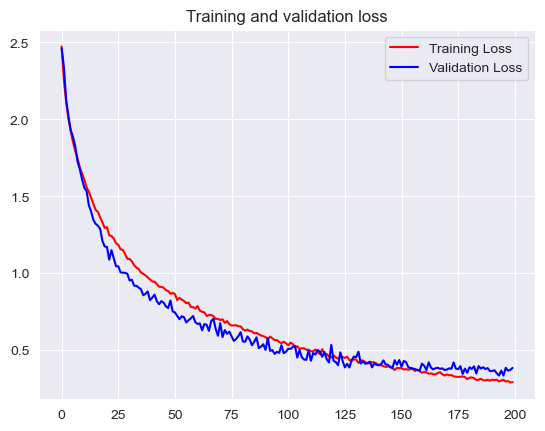

Accuracy on test set is:0.9199199080467224
Train:  (8987, 20, 130, 1) (8987,) Test:  (999, 20, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
            

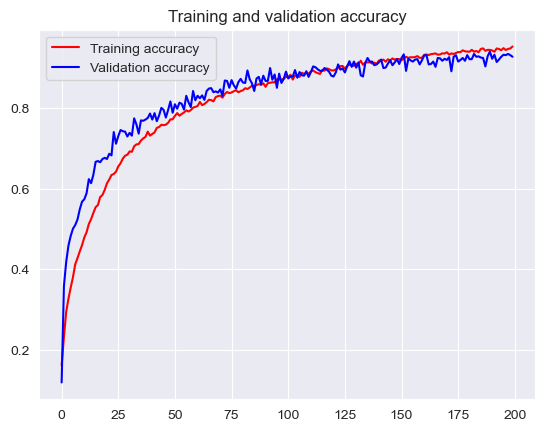

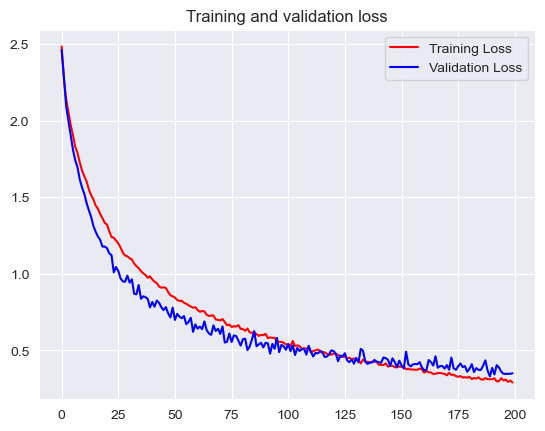

Accuracy on test set is:0.9279279112815857
Train:  (8987, 20, 130, 1) (8987,) Test:  (999, 20, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
            

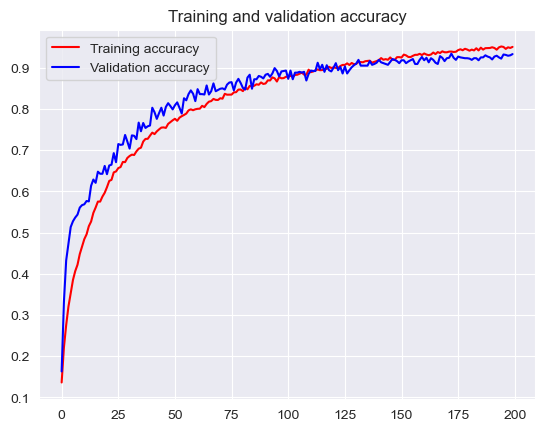

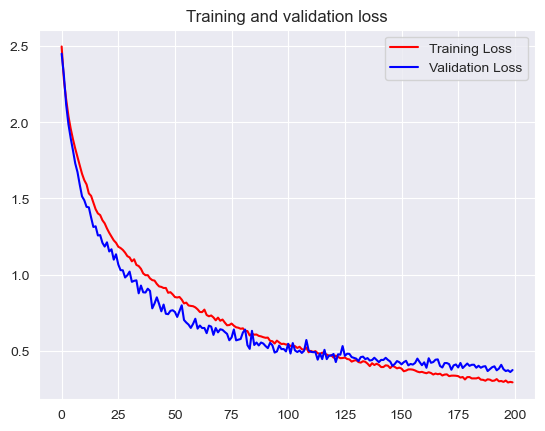

Accuracy on test set is:0.9329329133033752
Train:  (8987, 20, 130, 1) (8987,) Test:  (999, 20, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
            

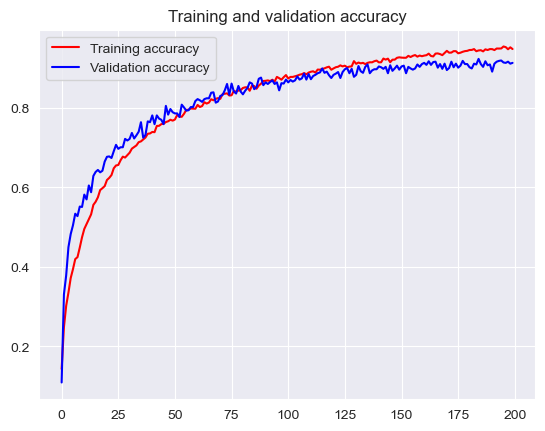

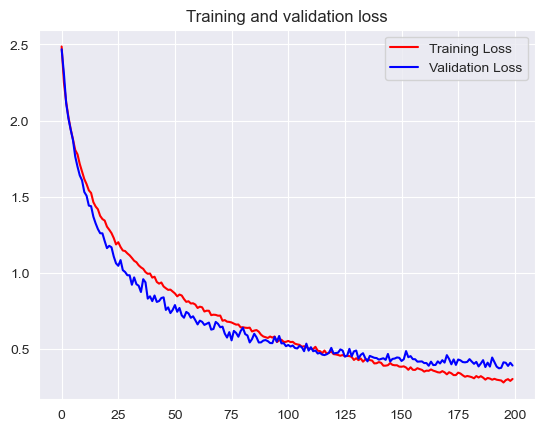

Accuracy on test set is:0.912912905216217
Train:  (8987, 20, 130, 1) (8987,) Test:  (999, 20, 130, 1) (999,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
             

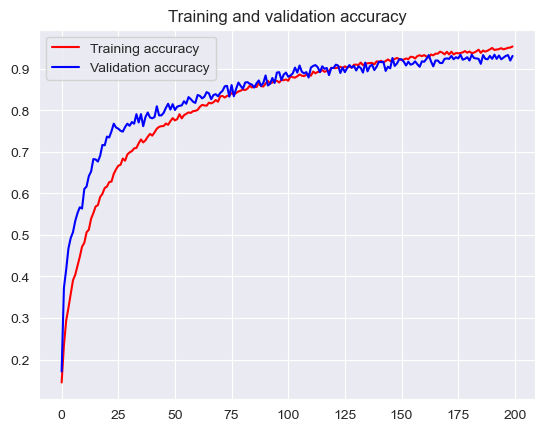

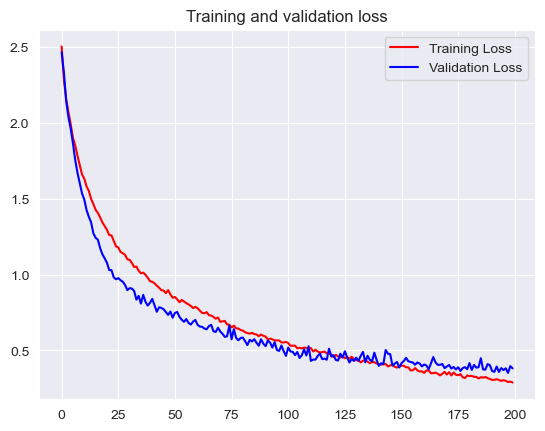

Accuracy on test set is:0.9309309124946594
Train:  (8988, 20, 130, 1) (8988,) Test:  (998, 20, 130, 1) (998,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
            

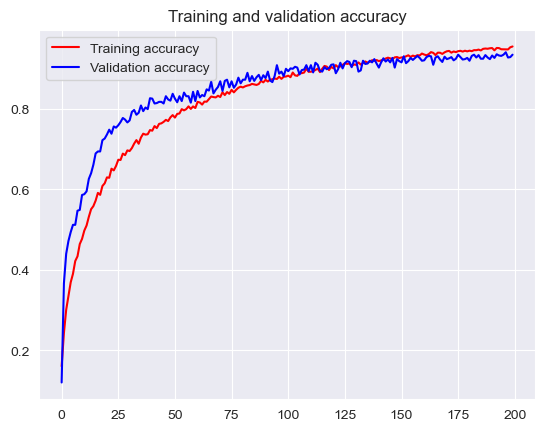

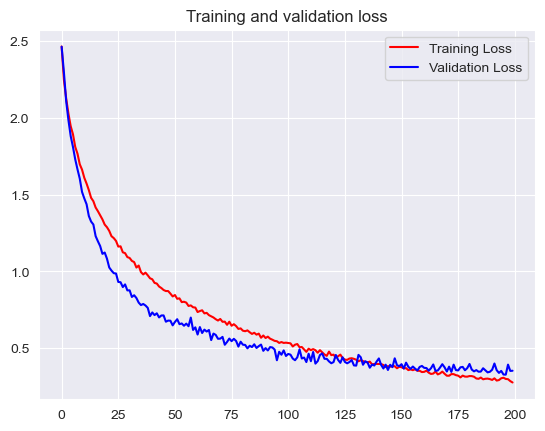

Accuracy on test set is:0.9348697662353516
Train:  (8988, 20, 130, 1) (8988,) Test:  (998, 20, 130, 1) (998,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
            

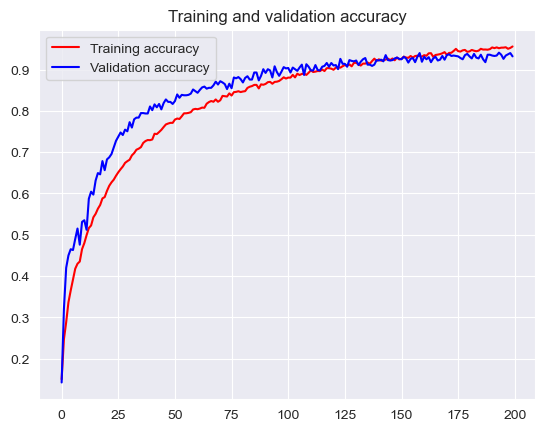

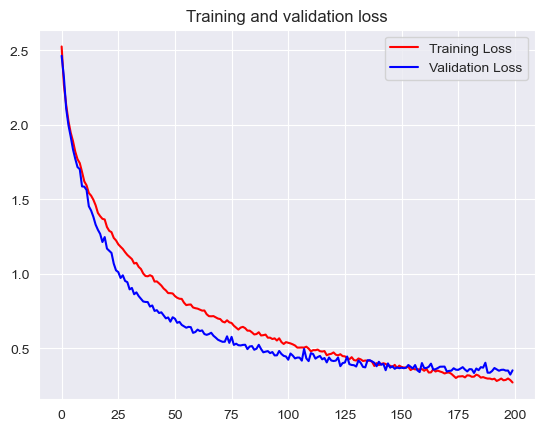

Accuracy on test set is:0.9318637251853943
Train:  (8988, 20, 130, 1) (8988,) Test:  (998, 20, 130, 1) (998,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
            

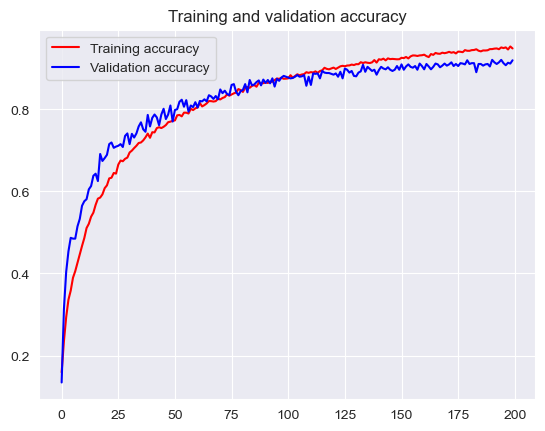

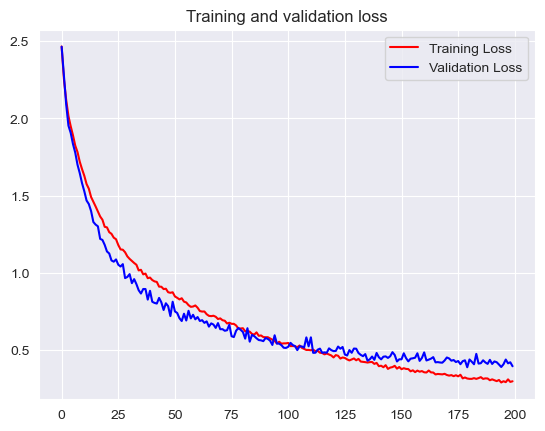

Accuracy on test set is:0.9198396801948547
Train:  (8988, 20, 130, 1) (8988,) Test:  (998, 20, 130, 1) (998,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
            

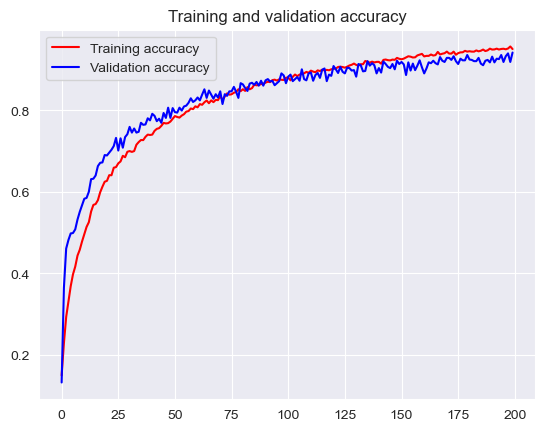

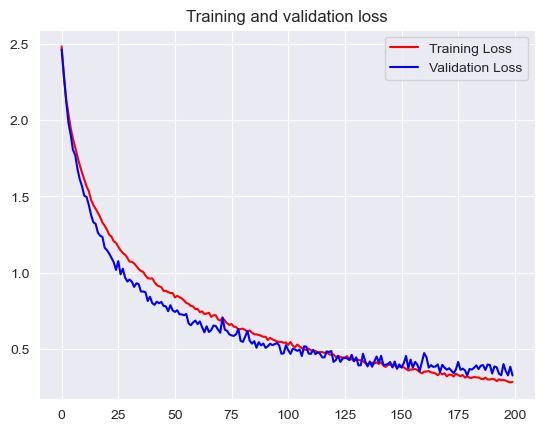

Accuracy on test set is:0.9418837428092957


In [52]:
x, y = shuffle(x, y)
skf = StratifiedKFold(n_splits=10)
# kf = KFold(n_splits=10, shuffle=True)
test_accuracies = []
for fold, (train_index, test_index) in enumerate(skf.split(x, y)):
    x_train = x[train_index]
    y_train = y[train_index]
    x_test = x[test_index]
    y_test = y[test_index]

    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]

    print('Train: ', x_train.shape, y_train.shape, 'Test: ', x_test.shape, y_test.shape)

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std


    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    model = build_model(input_shape)
    optimizer = keras.optimizers.Adam(learning_rate=0.00005) # 0.0001 # 0.00006
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    model.summary()

    # checkpoint_filepath = 'CNN-KFoldCV_Checkpoint/' + str(fold)
    # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True, initial_value_threshold=0.8, verbose=1)

    history = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              epochs=200,
              batch_size=32 #, callbacks=[model_checkpoint_callback]
              )

    # model.load_weights(checkpoint_filepath)

    test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
    test_accuracies.append(test_accuracy)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy' + str())
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    print("Accuracy on test set is:{}".format(test_accuracy))

    del model
    keras.backend.clear_session()
    gc.collect()

In [73]:
del model
keras.backend.clear_session()
gc.collect()

34230

In [2]:
# def manipulate(data, noise_factor):
#     noise = np.random.randn(len(data))
#     augmented_data = data + noise_factor * noise
#     # Cast back to same data type
#     augmented_data = augmented_data.astype(type(data[0]))
#     return augmented_data
#
# manipulate(x_train, 0.5)
# manipulate(y_train, 0.5)

MemoryError: Unable to allocate 2.72 TiB for an array with shape (11986, 65, 40, 11986) and data type float64

In [54]:
test_accuracies = np.array(test_accuracies)
print(test_accuracies, test_accuracies.dtype)
print('Mean = ', np.mean(test_accuracies))
print('Standard deviation = ', np.std(test_accuracies))

[0.93593591 0.91991991 0.92792791 0.93293291 0.91291291 0.93093091
 0.93486977 0.93186373 0.91983968 0.94188374] float64
Mean =  0.9289017379283905
Standard deviation =  0.008379475007018692


In [63]:
x, y = shuffle(x, y)
x = x[..., np.newaxis]

print('Shape: ', x.shape, y.shape)

mean = np.mean(x)
std = np.std(x)
x = (x - mean) / std

Shape:  (9986, 20, 130, 1) (9986,) Test: 


In [65]:
input_shape = (x.shape[1], x.shape[2], x.shape[3])
model = build_model(input_shape)
optimizer = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

model.summary()

# checkpoint_filepath = 'CNN-KFoldCV_Checkpoint_Final/'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True, initial_value_threshold=0.8, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 dropout (Dropout)           (None, 9, 64, 64)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 62, 128)        7

Epoch 1/200
313/313 [==============================] - 5s 13ms/step - loss: 2.4802 - accuracy: 0.1474
Epoch 2/200
313/313 [==============================] - 4s 12ms/step - loss: 2.2406 - accuracy: 0.2418
Epoch 3/200
313/313 [==============================] - 4s 12ms/step - loss: 2.1223 - accuracy: 0.2875
Epoch 4/200
313/313 [==============================] - 4s 12ms/step - loss: 2.0149 - accuracy: 0.3348
Epoch 5/200
313/313 [==============================] - 4s 12ms/step - loss: 1.9386 - accuracy: 0.3675
Epoch 6/200
313/313 [==============================] - 4s 12ms/step - loss: 1.8559 - accuracy: 0.3945
Epoch 7/200
313/313 [==============================] - 4s 12ms/step - loss: 1.7926 - accuracy: 0.4201
Epoch 8/200
313/313 [==============================] - 4s 12ms/step - loss: 1.7344 - accuracy: 0.4368
Epoch 9/200
313/313 [==============================] - 4s 12ms/step - loss: 1.6758 - accuracy: 0.4584
Epoch 10/200
313/313 [==============================] - 4s 12ms/step - loss: 1.639

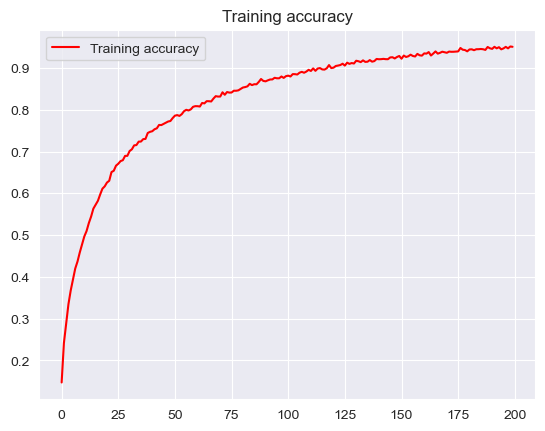

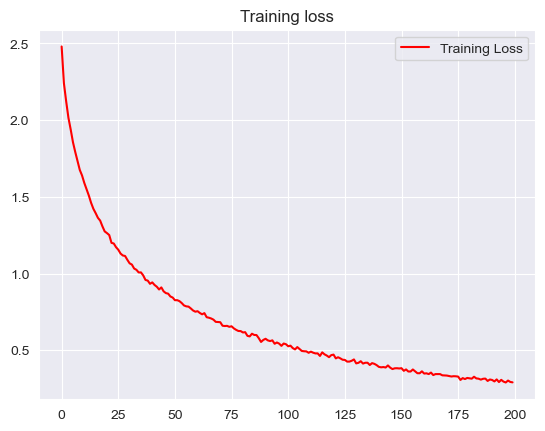

In [66]:
history = model.fit(x, y,
          epochs=200,
          batch_size=32
          )

# test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy' + str())
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

# print("Accuracy on test set is:{}".format(test_accuracy))



63/63 [==============================] - 1s 10ms/step


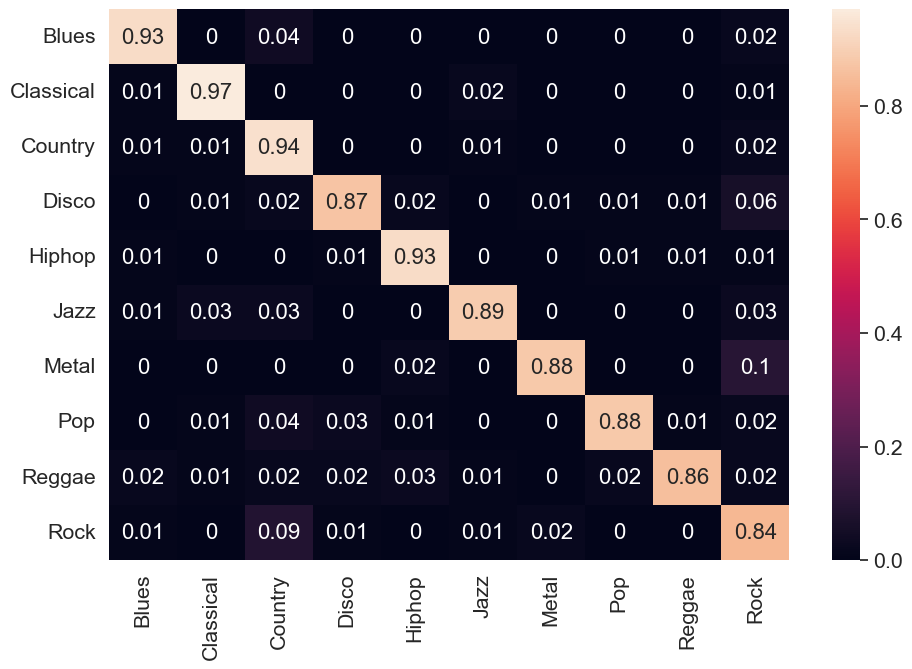

In [78]:
predictions = model.predict(x_test, batch_size=32, verbose=1)
predicted_indexes = []
for prediction in predictions:
    predicted_indexes.append(np.argmax(prediction))
predicted_indexes
conf_mat = confusion_matrix(y_test, predicted_indexes, normalize= 'true')
conf_mat = np.round(conf_mat, 2)
conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)
plt.figure(figsize = (10,7), dpi = 100)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()

In [71]:
model.save('saved_models/CNN-Kfold-MFCC')
mean_std = np.array([mean, std], dtype=np.float32)
np.save('saved_models/CNN-Kfold-MFCC-mean_std/mean_std.npy', mean_std)

INFO:tensorflow:Assets written to: saved_models/CNN-Kfold-MFCC\assets


INFO:tensorflow:Assets written to: saved_models/CNN-Kfold-MFCC\assets


FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/CNN-Kfold-MFCC-mean_std/mean_std.npy'

In [132]:
model = tf.keras.models.load_model('saved_models/CNN')
test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy on test set is:{}".format(test_accuracy))

63/63 [==============================] - 1s 11ms/step - loss: 0.5164 - accuracy: 0.8864
Accuracy on test set is:0.8863863945007324


In [133]:
def predict(model,x, y):
    
    x = x[np.newaxis, ...]
    prediction = model.predict(x)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index:{predicted_index}")
    
x = x_test[228]
y = y_test[228]
predict(model, x, y)

1/1 [==============================] - 0s 125ms/step
Expected index: 9, Predicted index:[9]


In [72]:
best = keras.models.load_model('saved_models/CNN-best')

In [73]:
best.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 38, 64)       640       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 64, 13, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_27 (Bat  (None, 64, 13, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_27 (ReLU)             (None, 64, 13, 64)        0         
                                                                 
 dropout_45 (Dropout)        (None, 64, 13, 64)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 62, 11, 128)      